# <span style='font-family:Lato,sans-serif;color:#fdbf11;font-size: 1em;'>Imports

In [125]:
# Aesthetics and utils
import os
from typing import Union, Optional, Tuple, Any
from IPython.core.display import display, HTML

# Data maniputalion
from datetime import datetime
import re
import numpy as np
import pandas as pd

# Saving binary files
import pickle

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go

# Disable warnings - useless most of the time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - Scikit-Learn
import sklearn

# Prior Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,\
	ConfusionMatrixDisplay, classification_report, roc_auc_score, f1_score, roc_curve, plot_roc_curve, precision_recall_curve

# Machine Learning - Others
# Hyper-parameter Bayesian Optimization
from hyperopt import Trials, hp, tpe, fmin, space_eval
# Why so serious?
from xgboost import XGBClassifier

# Model interpretation
from lime import lime_tabular

#_____________________________________________________________________________________________________________________________________

# Make terminal pretty
WHITE = '\033[39m'
CYAN = '\033[36m'
GREEN = '\033[32m'
RED = '\033[31m'

# Markdown want some too
# header 1 - yellow 
# <span style='font-family:Lato,sans-serif;color:#fdbf11;font-size: 1em;'>
# header 2 - blue 
# <span style='font-family:Lato,sans-serif;color:#1696d2;font-size: 1em; header 2'>

# Color pallete for plotting
colors = {
    'cyan': '#1696d2',
    'gray': '#5c5859',
    'black': '#000000',
    'yellow': '#fdbf11',
    'orange': '#ca5800',
    'magenta': '#af1f6b',
    'green': '#408941',
    'red': '#a4201d'
}

# Check Libraries version
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')


Numpy: 1.20.3
Pandas: 1.3.4
Sklearn: 1.0.2
Matplotlib: 3.4.3
Seaborn: 0.11.2


# <span style='font-family:Lato,sans-serif;color:#fdbf11;font-size: 1em;'>Create Function

In [92]:
class FeaturesCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, X, y=None):
        
        return self
    
    def fit_transform(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        X["credito_receita"] = X["AMT_CREDIT"]/X["AMT_INCOME_TOTAL"]
        X["anuidade_receita"] = X["AMT_ANNUITY"]/X["AMT_INCOME_TOTAL"]
        X["bens_receita"] = X["AMT_GOODS_PRICE"] / X["AMT_INCOME_TOTAL"]
        X["receita_pessoa"] = X["AMT_INCOME_TOTAL"] / X["CNT_FAM_MEMBERS"]

        # =======================================

        X["tempo_empregado_percent"] = np.clip(X["DAYS_EMPLOYED"] / X["DAYS_BIRTH"], 0, 1)

        # =======================================

        X["num_adultos"] = X["CNT_FAM_MEMBERS"] - X["CNT_CHILDREN"]
        X['tax_kids'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']

        # =======================================

        X['qtdd_pgtos'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']

        # =======================================

        X["EXT_SOURCE_MIN"]  = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis = 1)
        X["EXT_SOURCE_MAX"]  = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis = 1)
        X["EXT_SOURCE_MEAN"] = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis = 1)
        X["EXT_SOURCE_SD"]   = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis = 1)
        X["NUM_EXT_SOURCES"] = (~X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].isnull()).astype(int).sum(axis=1)

        # =======================================

        features_docs = [x for x in X.columns if "FLAG_DOCUMENT_" in x]
        X["NUM_DOCUMENTS"] = X[features_docs].sum(axis = 1)

        # =======================================

        X["DAY_APPR_PROCESS_START"] = X["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: "Weekend" if x in ["SATURDAY", "SUNDAY"]
                                                                            else "Working day")

        # =======================================

        X["OWN_CAR_AGE_RATIO"] = X["OWN_CAR_AGE"] / X["DAYS_BIRTH"]
        X["DAYS_ID_PUBLISHED_RATIO"] = X["DAYS_ID_PUBLISH"] / X["DAYS_BIRTH"]
        X["DAYS_REGISTRATION_RATIO"] = X["DAYS_REGISTRATION"] / X["DAYS_BIRTH"]

        return X

In [93]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop):
        
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        
        return self 

    def transform(self, X, y=None):
        
        return X.drop(columns = self.columns_to_drop)

In [101]:
params = {
	'train_df' : pd.read_csv('/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_train.csv'),
	'test_df' : pd.read_csv('/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_test_student.csv'),
	'ID_column' : 'SK_ID_CURR',
	'target_name' : 'TARGET',
	'train_size' : 0.8,
	'test_size' : 0.2,
	'stratify_target' : True,
	'FeaturesCreator' : FeaturesCreator(),
	'cols_to_drop' : ['CODE_GENDER'],
	'numeric_pipeline' : [
							('impute_num', SimpleImputer(strategy='mean')),
							('mms', MinMaxScaler())
						],
	'categorical_pipeline' : [
							('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
							('onehot', OneHotEncoder(handle_unknown='ignore'))
						],
	'estimator' : LogisticRegression,
	'estimator_default_params' : None,
	'metric_type' : 'classification',
	'plot_metrics' : True,
	'save_model' : True,
	'submit_file' : True,

	'random_state' : 42
}

In [102]:
# Main Function
def excalibur_II(**kwargs):

	# Read Train file
	df = kwargs['train_df']
	print(f'{CYAN}Train dataset loaded.{WHITE}')
	print(f'Observations: {df.shape[0]}\nFeatures: {df.shape[1]}\n')

	# Read Test file
	if 'test_df' in kwargs:
		test_df = kwargs['test_df']
		print(f'{CYAN}Test dataset loaded.{WHITE}')
		print(f'Observations: {test_df.shape[0]}\nFeatures: {test_df.shape[1]}\n')
		X_eval = test_df.drop(columns=kwargs['ID_column'])

	# Set features
	X = df.drop(columns=[kwargs['target_name'], kwargs['ID_column']])
	# Set target
	y = df[kwargs['target_name']]


	# Check stratify
	if kwargs['stratify_target']:
		stratify = y
	else:
		stratify = None

	# Create split
	X_train, X_test, y_train, y_test = train_test_split(X, y, 
														train_size=kwargs['train_size'], 
														test_size=kwargs['test_size'], 
														stratify=stratify, random_state=kwargs['random_state'])
	
	print(f'{CYAN}\nApplying feature engineering:{WHITE}\n')
	# Feature Engineering
	feature_eng_pipeline  = Pipeline([('create_surname', kwargs['FeaturesCreator']),
                     				('column_dropper', ColumnDropper(kwargs['cols_to_drop']))]
							).fit(X_train, y_train)
	# Apply new features
	X_train = feature_eng_pipeline.transform(X_train)
	X_test = feature_eng_pipeline.transform(X_test)
	X_eval = feature_eng_pipeline.transform(X_eval)

	# Define numeric features
	numeric_features     = X_train.select_dtypes(include=np.number).columns.tolist()
	# Define categorical features
	categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
	print(f'{CYAN}Train dataset size:{WHITE} {X_train.shape}')
	print(f'{CYAN}Test dataset size:{WHITE} {X_test.shape}')

	# Numeric features pipeline
	numeric_features_pipeline = Pipeline(kwargs['numeric_pipeline'])
	print(f'{CYAN}\nCreated Numeric Pipeline with the following transformers:{WHITE}')
	print(', '.join([str(transformer[1])[:-2] for transformer in kwargs['numeric_pipeline']]))

	# Categorical features pipeline
	categorical_features_pipeline = Pipeline(kwargs['categorical_pipeline'])
	print(f'{CYAN}\nCreated Categorical Pipeline with the following transformers:{WHITE}')
	print(', '.join([str(transformer[1])[:-2] for transformer in kwargs['categorical_pipeline']]))

	# Create Column transformer
	pre_processing_pipeline = ColumnTransformer([
		('numeric_transformer', numeric_features_pipeline, numeric_features),
		('categorical_transformer', categorical_features_pipeline ,categorical_features)
	])

	# Make pipeline and fit
	start_time =  datetime.now()
	print(f'{CYAN}Fitting model:{WHITE} ')
	pipeline = Pipeline([
		('pre_processing', pre_processing_pipeline),
		('estimator', kwargs['estimator'](random_state=kwargs['random_state']))
	]).fit(X_train, y_train)

	end_time = datetime.now()
	print(f'{CYAN}Time to fit model:{WHITE} ', str(end_time - start_time).split(".")[0])


	# Calculate metrics
	print(f'Score for baseline model with {kwargs["estimator"].__name__}')
	display_metrics(X_train, X_test, y_train, y_test, pipeline, metric_type=kwargs['metric_type'], plot=kwargs['plot_metrics'])

	if kwargs['save_model']:
		current_time = str(datetime.now()).replace(' ','_')[:-7]
		with open(f'{kwargs["estimator"].__name__}_{current_time}.pickle', 'wb') as file:
			pickle.dump(pipeline, file, protocol=pickle.HIGHEST_PROTOCOL)
			print(f'File saved on {os.path.realpath(file.name)}')
	
	# Create submit dataframe with predictions from the best model
	if kwargs['submit_file']:
		pd.DataFrame({
				kwargs['ID_column']: test_df[kwargs['ID_column']],
				'TARGET_prediction': pipeline.predict(X_eval),
				'TARGET_proba': pipeline.predict_proba(X_eval)[:,1]
			}).to_csv('submit_file.csv')
		print('Submit file saved.')


In [171]:

def read_data_frame(file_name, drop_id=None, verbose=True):
		# Read Train file
		df = pd.read_csv(file_name)
		# Drop ID if exists
		if drop_id:
			df.drop(columns=drop_id, inplace=True)
		# Print log
		if verbose:
			print(f'{CYAN}{file_name} dataset loaded.{WHITE}')
			print(f'Observations: {df.shape[0]}\nFeatures: {df.shape[1]}\n')
		return df

def apply_feature_engineering(feat_eng_pipe_params, y_train, X_train, X_test, X_eval=None):

		print(f'{CYAN}\nApplying feature engineering...{WHITE}\n')
		feature_eng_pipeline  = Pipeline(feat_eng_pipe_params).fit(X_train, y_train)

		# Transform features
		X_train = feature_eng_pipeline.transform(X_train)
		X_test = feature_eng_pipeline.transform(X_test)
		if any(X_eval):
			X_eval = feature_eng_pipeline.transform(X_eval)
			return X_train, X_test, X_eval
		else:
			return X_train, X_test

def create_preprocess_pipeline(X_train, numeric_params, categorical_params):
		# Define numeric/categorical features
		numeric_features     = X_train.select_dtypes(include=np.number).columns.tolist()
		categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

		# Create Column transformer with respective parameters
		pre_processing_pipeline = ColumnTransformer([
			('numeric_transformer', Pipeline(numeric_params), numeric_features),
			('categorical_transformer', Pipeline(categorical_params) ,categorical_features)
		])

		# Pipeline log
		print(f'{CYAN}\nCreating Numeric Pipeline with the following transformers:{WHITE}')
		print(', '.join([str(transformer[1]) for transformer in params['numeric_pipeline']]))
		print(f'{CYAN}\nCreating Categorical Pipeline with the following transformers:{WHITE}')
		print(', '.join([str(transformer[1]) for transformer in params['categorical_pipeline']]))
		
		return pre_processing_pipeline

def create_pipeline(X, y, pp_pipeline, estimator, default_params={}, random_state=None):
		
		start_time =  datetime.now()
		print(f'{CYAN}Fitting model:{WHITE} ')
		pipeline = Pipeline([
			('pre_processing', pp_pipeline),
			('estimator', estimator(**default_params, random_state=random_state))
		]).fit(X, y)
		end_time = datetime.now()
		print(f'{CYAN}Time to fit model:{WHITE} ', str(end_time - start_time).split(".")[0])

		return pipeline

def save_model_to_file(model, estimator):
		current_time = str(datetime.now()).replace(' ','_')[:-7]
		with open(f'{estimator.__name__}_{current_time}.pickle', 'wb') as file:
			pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)
			print(f'File saved on {os.path.realpath(file.name)}')

def save_submit_file(model, X_eval, eval_df, id_column):

		pd.DataFrame({
				id_column: eval_df[id_column],
				'TARGET_prediction': model.predict(X_eval),
				'TARGET_proba': model.predict_proba(X_eval)[:,1]
			}).to_csv('submit_file.csv')
		print('Submit file saved.')

def plot_roc_auc(y_test, y_proba_test):
	# get false positive rates and true positive rates
	fpr, tpr, _ = roc_curve(y_test, y_proba_test)
	# score for test dataset
	score = round(roc_auc_score(y_test, y_proba_test),3)
	# plot ROC AUC curve
	plt.figure(figsize=(8,6))
	plt.plot(fpr, tpr, label=f'Classifier AUC = {score}')
	plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), ls=':', label='Random = 0.5')
	plt.title('ROC AUC curve', fontsize=18, pad=20, loc='left')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.legend()
	plt.tight_layout()
	plt.show()
	
def plot_precision_recall(y_test, y_proba_test):
	# get precisions, recalls and thres
	precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
	# plot Precision-Recall curve
	plt.figure(figsize=(8,6))
	plt.plot(thresholds, precisions[:-1], label='Precision')
	plt.plot(thresholds, recalls[:-1], label='Recall', color='black')
	plt.title('Precision-Recall curve', fontsize=18, pad=20, loc='left')
	plt.xlabel('Tresholds cutoffs')
	plt.legend()
	plt.tight_layout()
	plt.show()

def plot_confusion_matrix(y_train, y_test, y_pred_train, y_pred_test):
	fig, ax = plt.subplots(1,2,figsize=(10,6))
	# plot Confusion Matrix from Train dataset
	fig.suptitle('Confusion Matrix', size=22)
	ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax[0], colorbar=False)
	ax[0].grid(False)
	ax[0].set_title('Train dataset', size=18, pad=20)

	# plot Confusion Matrix from Test dataset
	cf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax[1], colorbar=False)
	ax[1].grid(False)
	ax[1].set_title('Test dataset', size=18, pad=20)
	
	# coordinates to plot colorbar on the right plot
	cax = plt.axes([0.95, 0.21, 0.03, 0.60])
	plt.colorbar(cf.im_, cax=cax)
	plt.show()

def print_regression_metrics(y_train, y_test, y_pred_train, y_pred_test):
	print(f'{CYAN}Train metrics:{WHITE}')
	for metric in [r2_score, mean_absolute_error, mean_squared_error]:
		print(f'{metric.__name__}: {metric(y_train, y_pred_train):.3f}')
	print(f'{CYAN}Test metrics:{WHITE}')
	for metric in [r2_score, mean_absolute_error, mean_squared_error]:
		print(f'{metric.__name__}: {metric(y_test, y_pred_test):.3f}')

def print_classification_metrics(y_train, y_test, y_pred_train, y_pred_test, y_proba_train, y_proba_test):
	print(f'{CYAN}Train metrics:{WHITE}')
	print(f'{roc_auc_score.__name__} {roc_auc_score(y_train, y_proba_train):.3f}')
	print(f'{f1_score.__name__} {f1_score(y_train, y_pred_train):.3f}')
	print(f'{CYAN}Test metrics:{WHITE}')
	print(f'{roc_auc_score.__name__} {roc_auc_score(y_test, y_proba_test):.3f}')
	print(f'{f1_score.__name__} {f1_score(y_test, y_pred_test):.3f}')

def print_clustering_metrics():
	print('Clustering metrics to be implemented.')
# Metrics main
def display_metrics(X_train, X_test, y_train, y_test, estimator, metric_type, plot=True):

	# predict for train/test
	y_pred_train = estimator.predict(X_train)
	y_pred_test = estimator.predict(X_test)
	# predict proba for train/test
	y_proba_train = estimator.predict_proba(X_train)[:,1]
	y_proba_test = estimator.predict_proba(X_test)[:,1]

	if metric_type=='regression':
		print_regression_metrics(y_train, y_test, y_pred_train, y_pred_test)

	elif metric_type=='classification':
		print_classification_metrics(y_train, y_test, y_pred_train, y_pred_test, y_proba_train, y_proba_test)
	
	elif metric_type=='clustering':
		print_clustering_metrics()
	
	else:
		raise ValueError('Invalid metric type')
	
	if plot:
		plot_roc_auc(y_test, y_proba_test)

	if plot and metric_type=='classification':
		plot_precision_recall(y_test, y_proba_test)
		plot_confusion_matrix(y_train, y_test, y_pred_train, y_pred_test)

# Main function
def run_model(train_df:str, target_name:str, estimator:Any, metric_type:str,
			numeric_pipeline:list[Tuple[str, Any]], categorical_pipeline:list[Tuple[str, Any]], 
			train_size:float=0.8, test_size:float=0.2,
			estimator_params:dict={}, stratify:bool=False, 
			test_df:Optional[str]=None, id_column:Optional[str]=None,
			features_creator:Optional[Any]=None, cols_to_drop:Optional[list[str]]=None, 
			plot_metrics:bool=True, save_model:bool=False, submit_file:bool=False, random_state=42):
	""" 
   	Read data frame and apply the whole Sklearn workflow

	:param train_df: File name for the train dataset
	:param test_df: File name for the evaluation dataset, if any
	:param id_column: Name of the ID column from data frame , if any
	:param target_name: Name of the target column
	:param train_size: Size of train dataset when splitting
	:param test_size: Size of test dataset when splitting
	:param stratify: Choose if will stratify when splitting into train/test. Recommended if data is unbalanced
	:param features_creator: FeaturesCreator Object to perform feature engineering
	:param cols_to_drop: Name of the columns to drop, if any
	:param numeric_pipeline: Tuple with transformers for the pre-processing pipeline, ('name', Transformer())
	:param categorical_pipeline: Tuple with transformers parameters for the pre-processing pipeline, ('name', Transformer())
	:param estimator: Sklearn estimator to be used, e.g. GradientBoostingClassifier
	:param estimator_params: Optional parameters for the estimator
	:param metric_type: Type of metrics to evaluate ('regression','classification', 'clustering')
	:param plot_metrics: Choose to plot metrics results
	:param save_model: Choose to save model object with pickle
	:param submit_file: Choose to create a submit file with predictions from the evaluation dataset

	:return: None
	:rtype: -
	:raises Error: -
	"""
	
	# Read Train Data Frame
	df = read_data_frame(file_name=train_df, drop_id=id_column)
	X = df.drop(columns=target_name) # Set Features
	y = df[target_name]				 # Set Target

	# Read Test Data Frame
	if test_df:
		test_df = read_data_frame(file_name=test_df)
		# Set evaluation Data Frame
		X_eval = test_df.drop(columns=id_column).copy()
	
	# Check stratify
	if stratify:
		stratify = y
	else:
		stratify = None

	# Create split
	X_train, X_test, y_train, y_test = train_test_split(X, y, 
													train_size=train_size, 
													test_size=test_size, 
													stratify=stratify, 
													random_state=random_state)
	print(f'Train dataset size: {X_train.shape}')
	print(f'Test dataset size: {X_test.shape}')

	# Feature Engineering
	# Check pipeline params
	feat_eng_pipe_params = []
	if features_creator:
		feat_eng_pipe_params.append( ('create_surname', features_creator) )
	if cols_to_drop:
		feat_eng_pipe_params.append( ('column_dropper', ColumnDropper(cols_to_drop)) )

	# Apply Feature engineering
	if len(feat_eng_pipe_params) > 0:
		if any(test_df):
			X_train, X_test, X_eval = apply_feature_engineering(feat_eng_pipe_params, 
																y_train, X_train, X_test, X_eval)
		else:
			X_train, X_test = apply_feature_engineering(feat_eng_pipe_params, 
														y_train, X_train, X_test)
	# Create Pre-processing Pipeline
	pre_processing_pipeline = create_preprocess_pipeline(X_train=X_train,
													numeric_params=numeric_pipeline,
													categorical_params=categorical_pipeline)
	# Make pipeline and fit
	pipeline = create_pipeline(X=X_train, y=y_train, 
								pp_pipeline=pre_processing_pipeline, 
								estimator=estimator, default_params=estimator_params,
								random_state=random_state)
	# Display model metrics
	print(f'{GREEN}Metrics for {estimator.__name__} model:{WHITE}')
	display_metrics(X_train, X_test, y_train, y_test, pipeline, metric_type=metric_type, plot=plot_metrics)

	# Save model
	if save_model:
		save_model_to_file(model=pipeline, estimator=estimator)
		
	# Create submit dataframe with predictions from the best model
	if submit_file:
		save_submit_file(model=pipeline, X_eval=X_eval, eval_df=test_df, id_column=id_column)

In [173]:
!ls

LogisticRegression_2022-03-20_01:47:36.pickle
LogisticRegression_2022-03-20_01:55:15.pickle
LogisticRegression_2022-03-21_01:03:22.pickle
stellar_cycle_5.ipynb
submit_file.csv
template_exercicios.ipynb


/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_train.csv dataset loaded.
Observations: 246008
Features: 121

/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_test_student.csv dataset loaded.
Observations: 61503
Features: 121

Train dataset size: (196806, 120)
Test dataset size: (49202, 120)

Applying feature engineering...


Creating Numeric Pipeline with the following transformers:
SimpleImputer(), MinMaxScaler()

Creating Categorical Pipeline with the following transformers:
SimpleImputer(fill_value='unknow', strategy='constant'), OneHotEncoder(handle_unknown='ignore')
Fitting model: 
Time to fit model:  0:00:09
Metrics for LogisticRegression model:
Train metrics:
roc_auc_score 0.749
f1_score 0.017
Test metrics:
roc_auc_score 0.746
f1_score 0.011


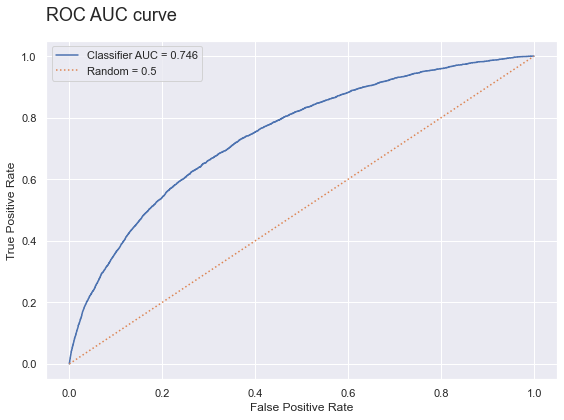

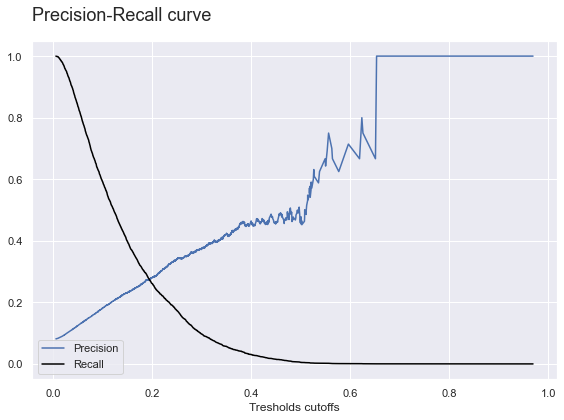

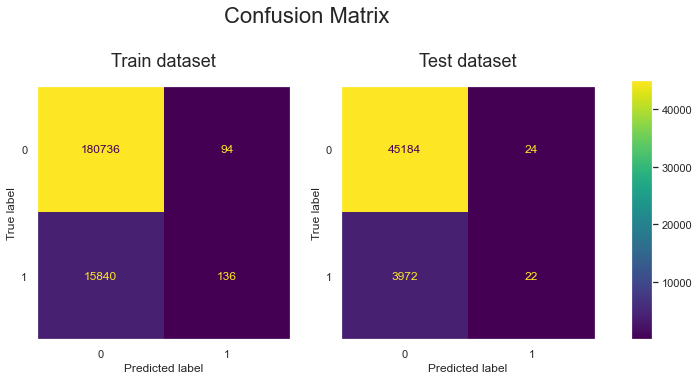

File saved on /Users/baiochi/OneDrive/GitHub/LetsCode/misc/LogisticRegression_2022-03-21_01:03:22.pickle
Submit file saved.


In [172]:
train_file_name = '/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_train.csv'
test_file_name = '/Users/baiochi/OneDrive/GitHub/LetsCode/5_Machine_Learning/projeto/data/application_test_student.csv'

run_model(
	train_df=train_file_name,
	test_df=test_file_name,
	id_column='SK_ID_CURR',
	target_name='TARGET',
	stratify=True,
	features_creator=FeaturesCreator(),
	cols_to_drop=['CODE_GENDER'],
	numeric_pipeline=[
						('impute_num', SimpleImputer(strategy='mean')),
						('mms', MinMaxScaler())
					],
	categorical_pipeline=[
							('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
							('onehot', OneHotEncoder(handle_unknown='ignore'))
						],
	estimator=LogisticRegression,
	metric_type='classification',
	plot_metrics=True,
	save_model=True,
	submit_file=True,
	random_state=42
)

In [129]:
params = {
	'train_df' : pd.read_csv(),
	'test_df' : pd.read_csv(),
	'ID_column' : 'SK_ID_CURR',
	'target_name' : 'TARGET',
	'train_size' : 0.8,
	'test_size' : 0.2,
	'stratify_target' : True,
	'FeaturesCreator' : FeaturesCreator(),
	'cols_to_drop' : ['CODE_GENDER'],
	'numeric_pipeline' : [
							('impute_num', SimpleImputer(strategy='mean')),
							('mms', MinMaxScaler())
						],
	'categorical_pipeline' : [
							('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
							('onehot', OneHotEncoder(handle_unknown='ignore'))
						],
	'estimator' : LogisticRegression,
	'estimator_default_params' : None,
	'metric_type' : 'classification',
	'plot_metrics' : True,
	'save_model' : True,
	'submit_file' : True,

	'random_state' : 42
}

Train dataset loaded.
Observations: 246008
Features: 122

Test dataset loaded.
Observations: 61503
Features: 121


Applying feature engineering:

Train dataset size: (196806, 137)
Test dataset size: (49202, 137)

Created Numeric Pipeline with the following transformers:
SimpleImputer, MinMaxScaler

Created Categorical Pipeline with the following transformers:
SimpleImputer(fill_value='unknow', strategy='constant, OneHotEncoder(handle_unknown='ignore
Fitting model: 
Time to fit model:  0:00:10
Score for baseline model with LogisticRegression
Train metrics:
roc_auc_score 0.749
f1_score 0.017
Test metrics:
roc_auc_score 0.746
f1_score 0.011


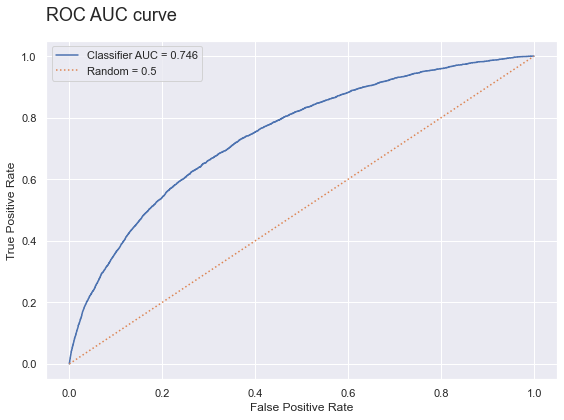

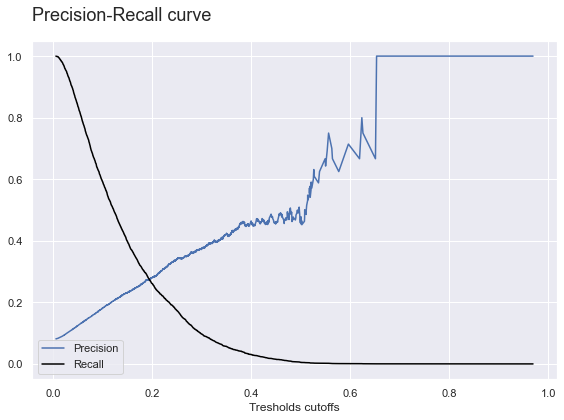

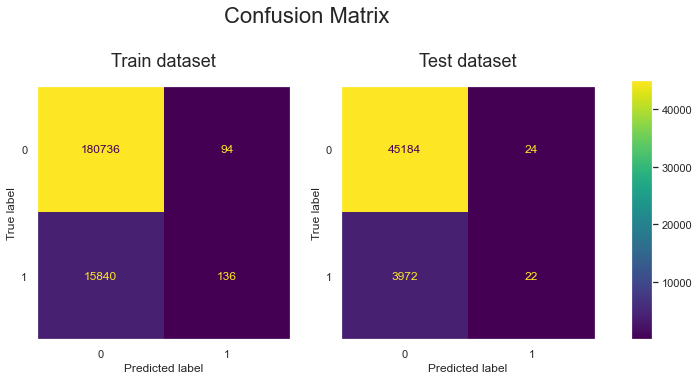

File saved on /Users/baiochi/OneDrive/GitHub/LetsCode/misc/LogisticRegression_2022-03-20_01:55:15.pickle
Submit file saved.


In [103]:
excalibur_II(**params)